# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
#The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [4]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error as ms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector as sf
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score as score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer, TransformedTargetRegressor
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsOneClassifier
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
from sklearn.svm import SVC, SVR
from sklearn.dummy import DummyClassifier
from collections import Counter
import graphviz
from sklearn.tree import export_graphviz as graph
from imblearn.over_sampling import SMOTE

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/praloysinha/Bank_campaigns/main/bank-additional.csv")

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
# No missing values were found in the dataset
# A 10% dataset comprising of 4,119 rows was selected for ML computation which was getting stuck for the entire dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [8]:
# The object datatype was coerced to string for better handling
df = df.convert_dtypes()

<Axes: xlabel='y', ylabel='count'>

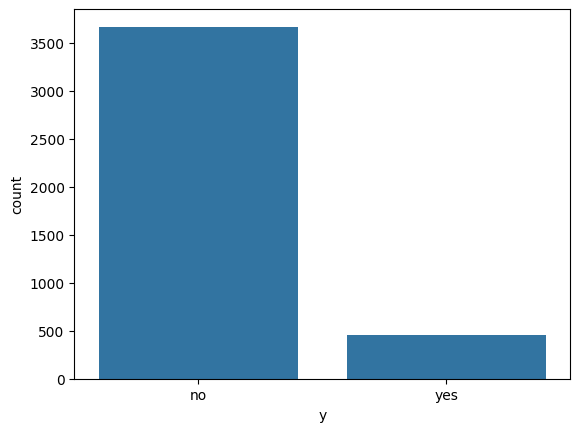

In [9]:
# Explored whether the data has imbalanced classes. The "no" class is 7 times the "yes" class and hence is greatly imbalanced
# We need to balance the data with SMOTE for better modelling
sns.countplot(data=df,x="y")

In [10]:
# Most of the campaign targets are in the age range of 30-40
px.violin(df,x = "age")

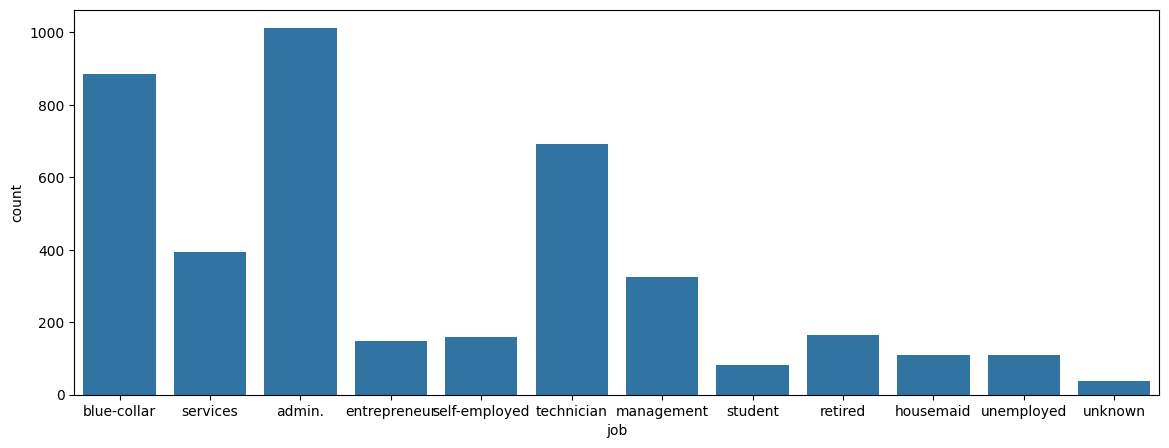

Counter({'admin.': 1012, 'blue-collar': 884, 'technician': 691, 'services': 393, 'management': 324, 'retired': 166, 'self-employed': 159, 'entrepreneur': 148, 'unemployed': 111, 'housemaid': 110, 'student': 82, 'unknown': 39})


In [11]:
# We should impute the "unknown" values of the job as it is a tiny part of the dataset
fig, ax = plt.subplots(figsize=(14, 5))
sns.countplot(data=df,x="job", ax = ax)
plt.show()
print(Counter(df["job"]))

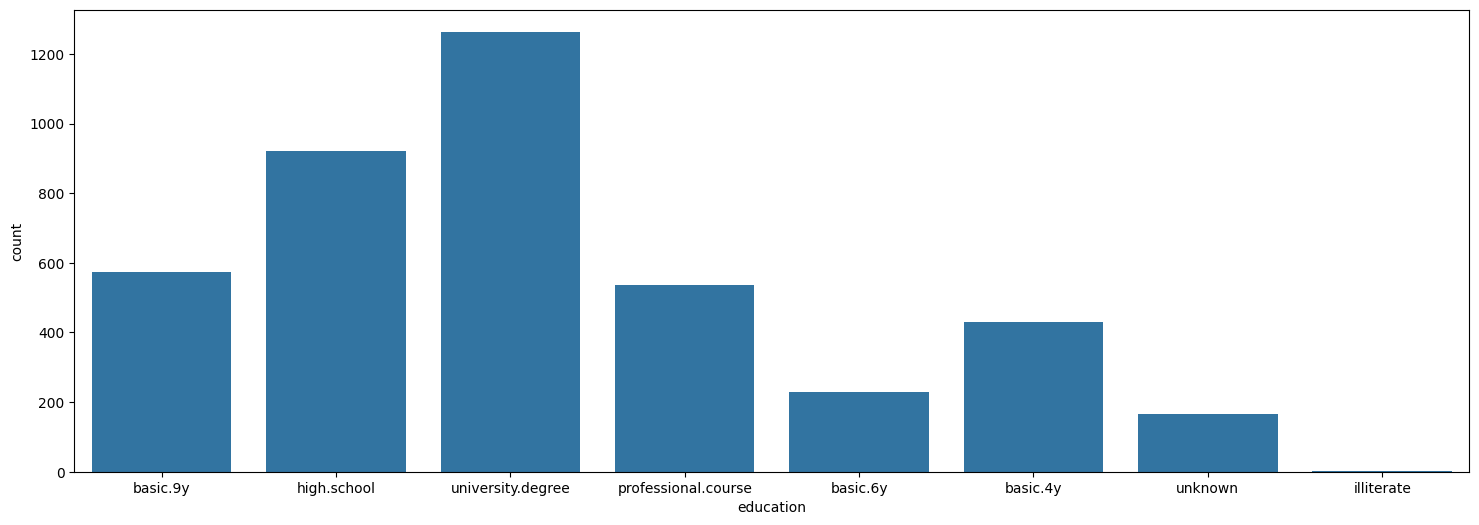

Counter({'university.degree': 1264, 'high.school': 921, 'basic.9y': 574, 'professional.course': 535, 'basic.4y': 429, 'basic.6y': 228, 'unknown': 167, 'illiterate': 1})


In [12]:
# We should impute the "unknown" values of the education as it is a tiny part of the dataset
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(data=df,x="education", ax = ax)
plt.show()
print(Counter(df["education"]))

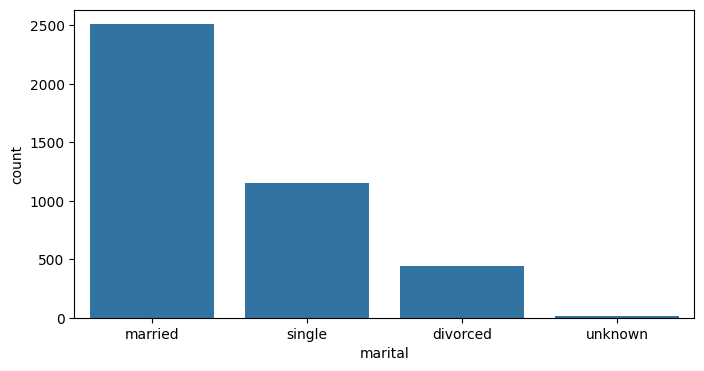

Counter({'married': 2509, 'single': 1153, 'divorced': 446, 'unknown': 11})


In [13]:
# We should impute the "unknown" values of the marital as it is a tiny part of the dataset
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(data=df,x="marital", ax = ax)
plt.show()
print(Counter(df["marital"]))

Counter({'no': 3315, 'unknown': 803, 'yes': 1})


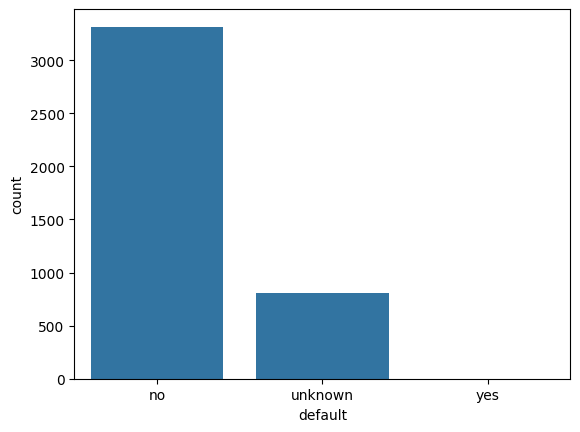

In [14]:
# Looking at the default column, we see it has a large number of unknown values which cannot be imputed since "yes" is just 1
# Hence we will drop this column since it is equivalent to a large number of missing values without possible imputation
sns.countplot(data=df,x="default")
print(Counter(df["default"]))

Counter({'yes': 2175, 'no': 1839, 'unknown': 105})


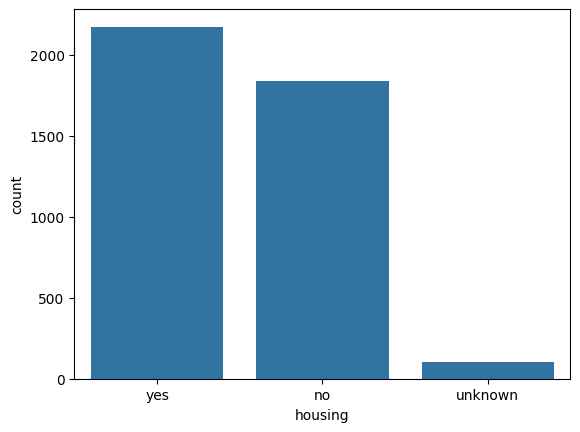

In [15]:
# We should impute the "unknown" values of the housing as it is a tiny part of the dataset
sns.countplot(data=df,x="housing")
print(Counter(df["housing"]))

Counter({'no': 3349, 'yes': 665, 'unknown': 105})


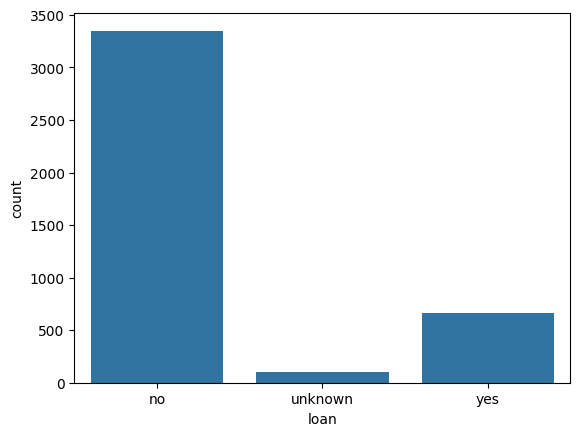

In [16]:
# We should impute the "unknown" values of the loan as it is a tiny part of the dataset
sns.countplot(data=df,x="loan")
print(Counter(df["loan"]))

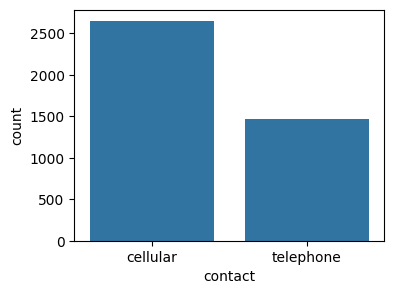

Counter({'cellular': 2652, 'telephone': 1467})


In [17]:
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(data=df,x="contact", ax = ax)
plt.show()
print(Counter(df["contact"]))

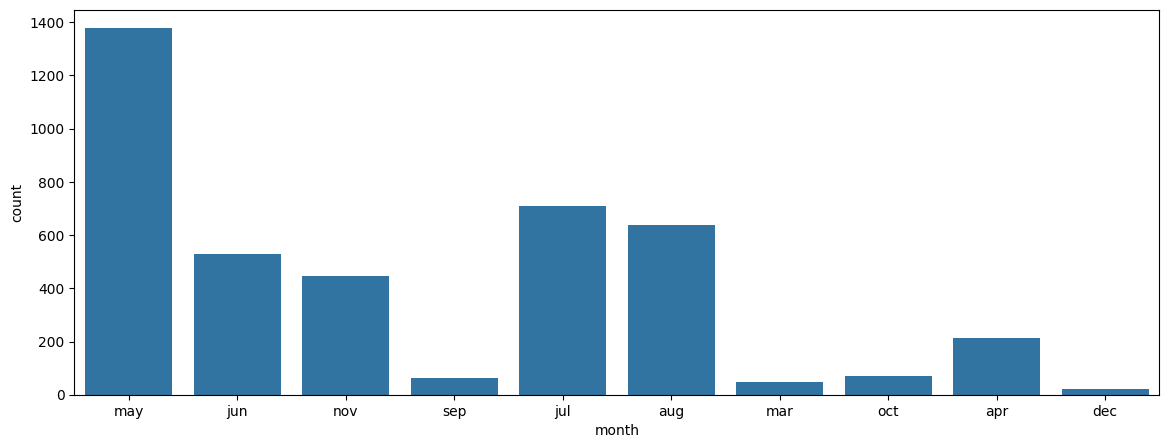

Counter({'may': 1378, 'jul': 711, 'aug': 636, 'jun': 530, 'nov': 446, 'apr': 215, 'oct': 69, 'sep': 64, 'mar': 48, 'dec': 22})


In [18]:
# May, July and August are driving most of the campaign calls
fig, ax = plt.subplots(figsize=(14,5))
sns.countplot(data=df,x="month", ax = ax)
plt.show()
print(Counter(df["month"]))

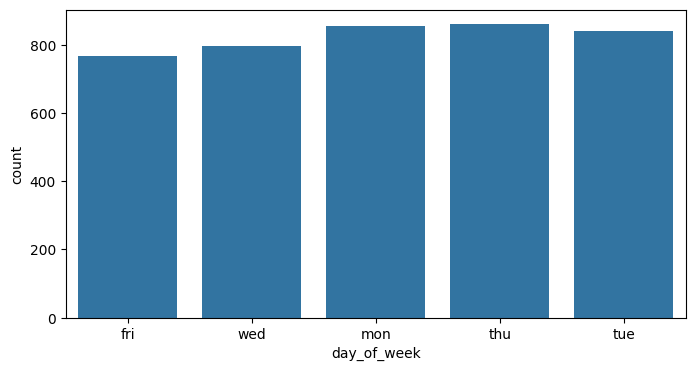

Counter({'thu': 860, 'mon': 855, 'tue': 841, 'wed': 795, 'fri': 768})


In [19]:
# The days of the week have similar volumes
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=df,x="day_of_week", ax = ax)
plt.show()
print(Counter(df["day_of_week"]))

In [20]:
px.violin(df,x = "campaign")

In [21]:
# We can ignore this column as almost all contacts are new and have never been contacted and hence the value 999
px.histogram(df,x = "pdays")

In [22]:
# We can ignore this column as almost all contacts have not been contacted previously
px.histogram(df,x = "previous")

Counter({'nonexistent': 3523, 'failure': 454, 'success': 142})


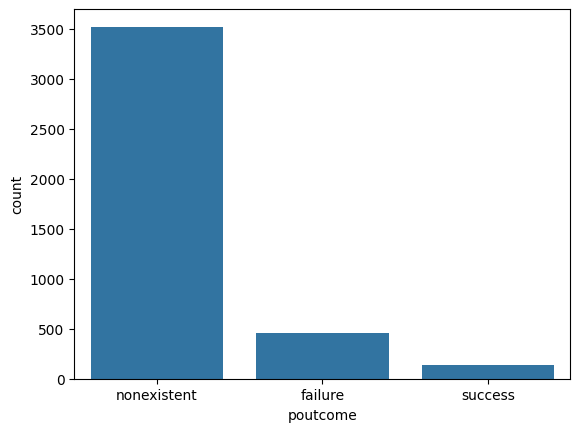

In [23]:
# We should not consider the poutcome column as "nonexistent" values are far higher & multiple times the existing values.
# Hence it is impossible to impute these values
sns.countplot(data=df,x="poutcome")
print(Counter(df["poutcome"]))

In [24]:
# It is mentioned in the note that this attribute highly affects the output target (e.g., if duration=0 then y='no').
# Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.
# Thus, this input should only be included for benchmark purposes and should be discarded if the intention
# is to have a realistic predictive model.
px.violin(df,x = "duration")

In [25]:
px.violin(df,x = "cons.price.idx")

In [26]:
px.violin(df,x = "euribor3m")

In [27]:
px.violin(df,x = "nr.employed")

In [28]:
px.violin(df,x = "emp.var.rate")

In [29]:
px.violin(df,x = "cons.conf.idx")

In [30]:
# We are dropping columns due to above mentioned reasons - ["default", "pdays", "previous", "poutcome", "duration"]

df1 = df.drop(columns = ["default", "pdays", "previous", "poutcome", "duration"] )
df1

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,2,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,telephone,may,fri,4,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,yes,no,telephone,jun,wed,1,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,unknown,unknown,telephone,jun,fri,3,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,1,-0.1,93.2,-42.0,4.191,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,yes,yes,cellular,jul,thu,1,1.4,93.918,-42.7,4.958,5228.1,no
4115,39,admin.,married,high.school,yes,no,telephone,jul,fri,1,1.4,93.918,-42.7,4.959,5228.1,no
4116,27,student,single,high.school,no,no,cellular,may,mon,2,-1.8,92.893,-46.2,1.354,5099.1,no
4117,58,admin.,married,high.school,no,no,cellular,aug,fri,1,1.4,93.444,-36.1,4.966,5228.1,no


In [31]:
# We will impute the values of "unknown" with the most frequent method
df1["job"] = np.where(df1["job"] == "unknown", "admin.",df1["job"])

In [32]:
df1["education"] = np.where(df1["education"] == "unknown", "university.degree",df1["education"])

In [33]:
df1["marital"] = np.where(df1["marital"] == "unknown", "married",df1["marital"])

In [34]:
df1["housing"] = np.where(df1["housing"] == "unknown", "yes",df1["housing"])

In [35]:
df1["loan"] = np.where(df1["loan"] == "unknown", "no",df1["loan"])

In [36]:
# The dataframe has been created with the columns which are relevant for modelling and replacing the "unknown" values
df1

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,2,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,telephone,may,fri,4,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,yes,no,telephone,jun,wed,1,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,yes,no,telephone,jun,fri,3,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,1,-0.1,93.2,-42.0,4.191,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,yes,yes,cellular,jul,thu,1,1.4,93.918,-42.7,4.958,5228.1,no
4115,39,admin.,married,high.school,yes,no,telephone,jul,fri,1,1.4,93.918,-42.7,4.959,5228.1,no
4116,27,student,single,high.school,no,no,cellular,may,mon,2,-1.8,92.893,-46.2,1.354,5099.1,no
4117,58,admin.,married,high.school,no,no,cellular,aug,fri,1,1.4,93.444,-36.1,4.966,5228.1,no


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [37]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   Int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   housing         4119 non-null   object 
 5   loan            4119 non-null   object 
 6   contact         4119 non-null   string 
 7   month           4119 non-null   string 
 8   day_of_week     4119 non-null   string 
 9   campaign        4119 non-null   Int64  
 10  emp.var.rate    4119 non-null   Float64
 11  cons.price.idx  4119 non-null   Float64
 12  cons.conf.idx   4119 non-null   Float64
 13  euribor3m       4119 non-null   Float64
 14  nr.employed     4119 non-null   Float64
 15  y               4119 non-null   string 
dtypes: Float64(5), Int64(2), object(5), string(4)
memory usage: 543.2+ KB


In [38]:
# The Business Objective is to evaluate the different classifers like KNN, Logistic Regression, Decision Tree and
# Support Vector Machines on the bank campaigns dataset in predicting the right classification whether the persons are
# agreeing to the loan offer made in the campaign

In [39]:
# The approach will be to model using these classifiers on the different demographic and campaign data of the persons
# reached out via telephone from the bank.
# In this business problem, we should ideally be able to predict as many people who are likely to take the loan. Hence precision score is very important to monitor and optimize.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [41]:
# Created the feature and target columns for modelling and saw the imbalanced classes
X = df1.drop(columns = "y")
y = df1["y"]
print(Counter(y))

Counter({'no': 3668, 'yes': 451})


In [59]:
X.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [65]:
# Encoded the categerical variables and scaled the numerical variables
transformer = make_column_transformer((OneHotEncoder(drop = "if_binary"),['job', 'marital', 'education', 'housing', 'loan', 'contact','month', 'day_of_week']), (StandardScaler(),['age', 'campaign', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']))
X1 = pd.DataFrame(transformer.fit_transform(X).toarray(), columns = transformer.get_feature_names_out() )
X1

,onehotencoder__job_admin.,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,...,onehotencoder__day_of_week_thu,onehotencoder__day_of_week_tue,onehotencoder__day_of_week_wed,standardscaler__age,standardscaler__campaign,standardscaler__emp.var.rate,standardscaler__cons.price.idx,standardscaler__cons.conf.idx,standardscaler__euribor3m,standardscaler__nr.employed
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.980752,-0.209228,-1.206054,-1.185448,-1.240939,-1.331707,-0.914779
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-0.107991,0.569634,0.649441,0.715193,0.892269,0.711698,0.332862
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-1.465619,-0.598660,0.841389,1.528273,-0.283172,0.773427,0.836535
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-0.204965,0.180203,0.841389,1.528273,-0.283172,0.771697,0.836535
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.667795,-0.598660,-0.118350,-0.655478,-0.326707,0.328632,0.398028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-0.980752,-0.598660,0.841389,0.583995,-0.479079,0.771120,0.836535
4115,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.107991,-0.598660,0.841389,0.583995,-0.479079,0.771697,0.836535
4116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.271672,-0.209228,-1.206054,-1.185448,-1.240939,-1.308054,-0.914779
4117,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.734503,-0.598660,0.841389,-0.234264,0.957571,0.775735,0.836535


In [66]:
# Created a balanced data using SMOTE
oversample = SMOTE()
X1,y = oversample.fit_resample(X1,y)
print(Counter(y))

Counter({'no': 3668, 'yes': 3668})


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [68]:
#Created the test - train split
X_train,X_test,y_train,y_test = train_test_split(X1,y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [70]:

#Created the baseline model using the Dummy Classifier


In [78]:
results = {
    'Model' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'Train Time' : [],
    'Inference Time' : []
}
models = {
    'Dummy Classifier' : DummyClassifier(strategy = "stratified")
}

import time
for model_name, model in models.items():
  start_time = time.time()
  model.fit(X_train, y_train)
  train_time = time.time() - start_time

  start_time = time.time()
  y_pred = model.predict(X_test)
  inference_time = time.time() - start_time

  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred, pos_label = "yes")
  recall = metrics.recall_score(y_test, y_pred, pos_label = "yes")
  f1 = metrics.f1_score(y_test, y_pred, pos_label = "yes")

  results['Model'].append(model_name)
  results['Accuracy'].append(accuracy)
  results['Precision'].append(precision)
  results['Recall'].append(recall)
  results['F1-Score'].append(f1)
  results['Train Time'].append(train_time)
  results['Inference Time'].append(inference_time)

In [79]:
# We have to beat a baseline of accuracy of 50.5% and precision of 51.8% of the Dummy Classifier by the other models
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1-Score,Train Time,Inference Time
0,Dummy Classifier,0.504907,0.518602,0.488842,0.503282,0.014056,0.000707


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [92]:
models = {
    'Logistic Regression' : LogisticRegression()
}


### Problem 9: Score the Model

What is the accuracy of your model?

In [93]:
import warnings
warnings.filterwarnings("ignore")
results1 = {
    'Model' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'Train Time' : [],
    'Inference Time' : []
}
for model_name, model in models.items():
  start_time = time.time()
  model.fit(X_train, y_train)
  train_time = time.time() - start_time

  start_time = time.time()
  y_pred = model.predict(X_test)
  inference_time = time.time() - start_time

  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred, pos_label = "yes")
  recall = metrics.recall_score(y_test, y_pred, pos_label = "yes")
  f1 = metrics.f1_score(y_test, y_pred, pos_label = "yes")

  results1['Model'].append(model_name)
  results1['Accuracy'].append(accuracy)
  results1['Precision'].append(precision)
  results1['Recall'].append(recall)
  results1['F1-Score'].append(f1)
  results1['Train Time'].append(train_time)
  results1['Inference Time'].append(inference_time)
pd.DataFrame(results1)

,Model,Accuracy,Precision,Recall,F1-Score,Train Time,Inference Time
0,Logistic Regression,0.718648,0.786003,0.620616,0.693587,0.133755,0.004544


In [ ]:
# The accuracy of a simple Logistic Model is 72% and a precision of 78.6%

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [89]:
models = {
    'Dummy Classifier' : DummyClassifier(strategy = "stratified"),
    'Logistic Regression' : LogisticRegression(),
    "KNN" : KNeighborsClassifier(),
    "Decision Tree" : DT(),
    "Support Vector Machines" : SVC()
}


In [91]:
import warnings
warnings.filterwarnings("ignore")
results2 = {
    'Model' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'Train Time' : [],
    'Inference Time' : []
}
for model_name, model in models.items():
  start_time = time.time()
  model.fit(X_train, y_train)
  train_time = time.time() - start_time

  start_time = time.time()
  y_pred = model.predict(X_test)
  inference_time = time.time() - start_time

  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred, pos_label = "yes")
  recall = metrics.recall_score(y_test, y_pred, pos_label = "yes")
  f1 = metrics.f1_score(y_test, y_pred, pos_label = "yes")

  results2['Model'].append(model_name)
  results2['Accuracy'].append(accuracy)
  results2['Precision'].append(precision)
  results2['Recall'].append(recall)
  results2['F1-Score'].append(f1)
  results2['Train Time'].append(train_time)
  results2['Inference Time'].append(inference_time)
pd.DataFrame(results2)

,Model,Accuracy,Precision,Recall,F1-Score,Train Time,Inference Time
0,Dummy Classifier,0.502726,0.515183,0.522848,0.518987,0.011566,0.000601
1,Logistic Regression,0.718648,0.786003,0.620616,0.693587,0.616155,0.015075
2,KNN,0.845692,0.769672,0.997875,0.869042,0.038107,0.719720
3,Decision Tree,0.899128,0.899577,0.904357,0.901961,0.189006,0.008510
4,Support Vector Machines,0.846238,0.875713,0.816153,0.844884,2.363071,0.527610


In [ ]:
# The above table is a suammry of the scores and time taken for the base models for each of the classifiers
# The Decision Tree is reaching the accuracy of almost 90% in accuracy and precision and taking relatively less time as well. SVM also has a good precision of 87% but takes higher time to train.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [98]:
knn_model = KNeighborsClassifier()
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [128]:
lr_model = LogisticRegression(solver = "liblinear")
lr_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [100]:
dt_model = DT()
dt_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [101]:
SVC_model = SVC()
SVC_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [129]:
k_trial = {'n_neighbors':range(1,10)}
l_trial = {'C': [0.2, 0.4,0.6, 0.8], 'penalty': ["l1","l2"] }
dt_trial = {'max_depth': [5,6,7,8], 'criterion': ["gini", "entropy"]}
sv_trial = {'degree': [5,6,7], 'kernel': ['poly',"rbf"]}

In [131]:
models = {
    'Dummy Classifier' : DummyClassifier(strategy = "stratified"),
    "Logistic Regression" : GridSearchCV(lr_model,l_trial, scoring = "precision", cv = 5),
    "KNN" : GridSearchCV(knn_model,k_trial, scoring = "precision", cv = 5),
    "Decision Tree" : GridSearchCV(dt_model,dt_trial, scoring = "precision", cv = 5),
    "Support Vector Machines" : GridSearchCV(SVC_model,sv_trial, scoring = "precision", cv = 5),
}


In [132]:
warnings.filterwarnings("ignore")
results3 = {
    'Model' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'Train Time' : [],
    'Inference Time' : []
}
for model_name, model in models.items():
  start_time = time.time()
  model.fit(X_train, y_train)
  train_time = time.time() - start_time

  start_time = time.time()
  y_pred = model.predict(X_test)
  inference_time = time.time() - start_time

  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred, pos_label = "yes")
  recall = metrics.recall_score(y_test, y_pred, pos_label = "yes")
  f1 = metrics.f1_score(y_test, y_pred, pos_label = "yes")

  results3['Model'].append(model_name)
  results3['Accuracy'].append(accuracy)
  results3['Precision'].append(precision)
  results3['Recall'].append(recall)
  results3['F1-Score'].append(f1)
  results3['Train Time'].append(train_time)
  results3['Inference Time'].append(inference_time)
pd.DataFrame(results3)

,Model,Accuracy,Precision,Recall,F1-Score,Train Time,Inference Time
0,Dummy Classifier,0.489640,0.502732,0.488842,0.495690,0.006660,0.000561
1,Logistic Regression,0.718648,0.784471,0.622742,0.694313,5.556243,0.005544
2,KNN,0.906761,0.850000,0.993624,0.916218,4.875443,0.152312
3,Decision Tree,0.764995,0.895963,0.613177,0.728076,1.593697,0.002081
4,Support Vector Machines,0.806434,0.885526,0.715197,0.791299,42.599969,0.288018


In [ ]:
# With the optimization through the Grid Search, these are the
# We can see that KNN has vastly increased its precision from 77% to 85%
# The Logistic Regression has a similar accuracy at 78% but halved its inference time which means lesser complexity
# Decision Tree has a similar accuracy of ~90% in comparison to the initial one but the inference time is reduced 4 times
# SVM has a slight betterment of precision to 88.5% and the inference time has been halved

In [133]:
knn_opt = GridSearchCV(knn_model,k_trial, scoring = "precision", cv = 5).fit(X_train, y_train)
dt_opt = GridSearchCV(dt_model,dt_trial, scoring = "precision", cv = 5).fit(X_train, y_train)

In [134]:
SVC_opt = GridSearchCV(SVC_model,sv_trial, scoring = "precision", cv = 5).fit(X_train, y_train)

In [135]:
lr_opt = GridSearchCV(lr_model,l_trial, scoring = "precision", cv = 5).fit(X_train, y_train)

In [136]:
# The best model of KNN has a n of 1 which means it is a highly complex model and prone to outliers influence.
knn_opt.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [137]:
# The Decision Tree best model has a max depth of 5 which is relatively easy to comprehend and does not complicate the model too much
dt_opt.best_estimator_

DecisionTreeClassifier(max_depth=5)

In [138]:
# The Logistic Regression best model is a highly regularized one wwith C = 0.2 and lasso as penalty and hence will have lesser complexity
# Feature selection was automatically done with this highly regularized model
lr_opt.best_estimator_

LogisticRegression(C=0.2, penalty='l1', solver='liblinear')

In [139]:
# The SVC best model is at polynomial degree 5 and is at medium complexity which justifes the reduction in inference time
SVC_opt.best_estimator_

SVC(degree=5, kernel='poly')

##### Questions

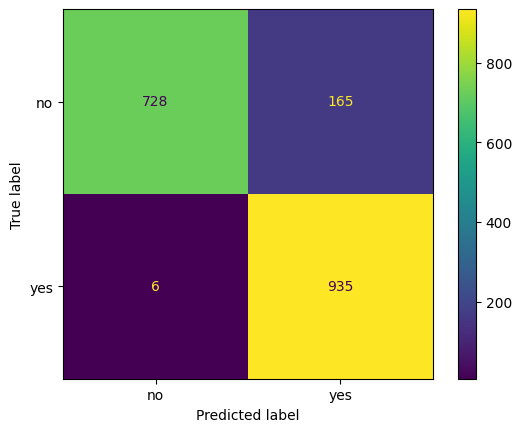

In [140]:
# KNN Confusion Matrix
confusion_mat = ConfusionMatrixDisplay.from_predictions(y_test,knn_opt.predict(X_test))

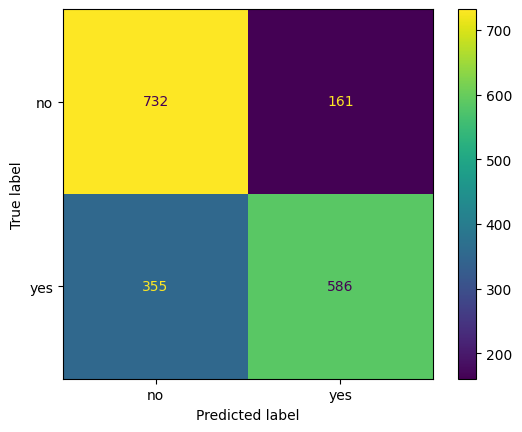

In [141]:
# Logistic Regression Confusion Matrix
confusion_mat = ConfusionMatrixDisplay.from_predictions(y_test,lr_opt.predict(X_test))

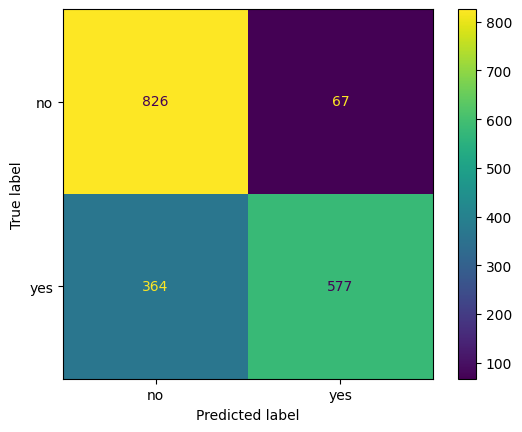

In [142]:
# Decision Tree Confusion Matrix
confusion_mat = ConfusionMatrixDisplay.from_predictions(y_test,dt_opt.predict(X_test))

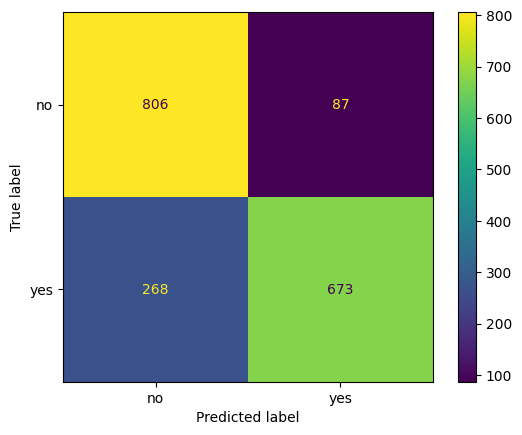

In [143]:
# Support Vector Machines Confusion Matrix
confusion_mat = ConfusionMatrixDisplay.from_predictions(y_test,SVC_opt.predict(X_test))

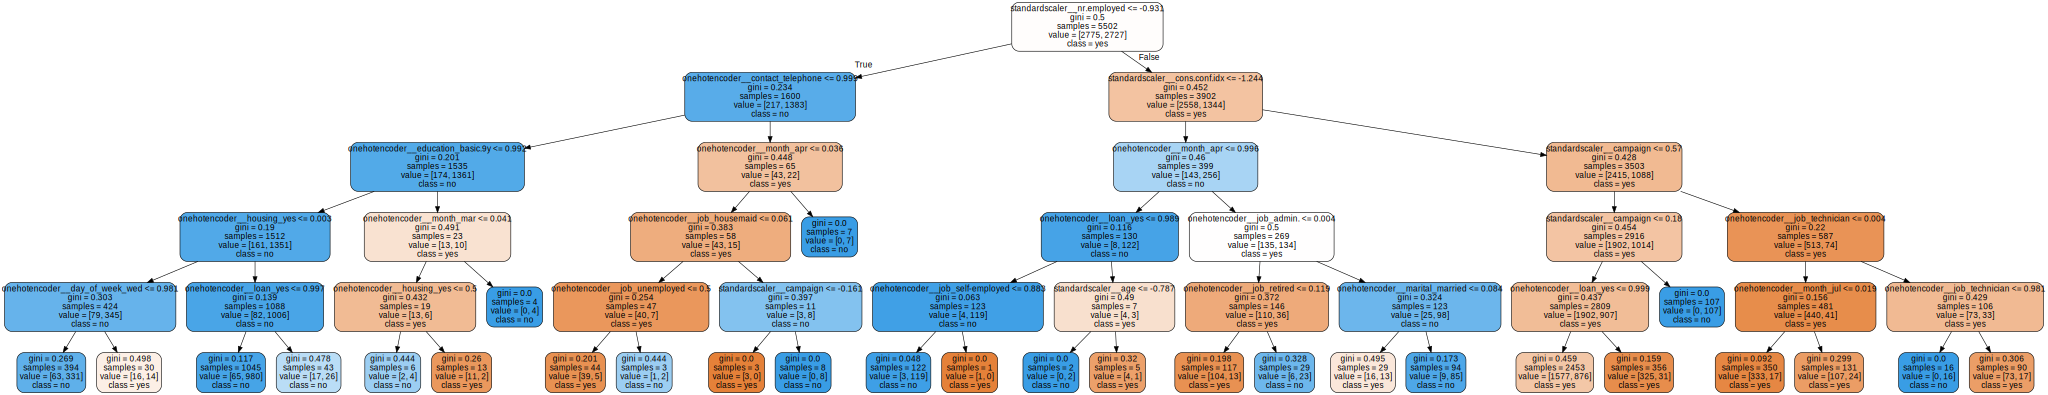

In [150]:
# Tree view of the Decision Tree best model
dot_data1 = graph(dt_opt.best_estimator_, class_names = ["yes","no"], feature_names = X1.columns, rounded = True, filled = True)
diag1 = graphviz.Source(dot_data1)
diag1.render(format = "png",filename = "loan_tree1")
diag1

In [147]:
# Support indices of the SVM best model
pd.DataFrame(SVC_opt.best_estimator_.support_)

,0
0,1
1,2
2,7
3,11
4,13
...,...
3005,5493
3006,5496
3007,5498
3008,5499


In [148]:
cf = pd.DataFrame(lr_opt.best_estimator_.coef_,
                      columns = X1.columns)
cf1=pd.melt(cf,var_name="features",value_name="Coeff")

In [149]:
cf1["abs_coeff"] = abs(cf1["Coeff"])
cf1.sort_values("abs_coeff",ascending = False).head(10)

,features,Coeff,abs_coeff
29,onehotencoder__month_mar,1.590408,1.590408
41,standardscaler__emp.var.rate,-1.305320,1.305320
23,onehotencoder__contact_telephone,-0.894449,0.894449
42,standardscaler__cons.price.idx,0.885742,0.885742
6,onehotencoder__job_self-employed,-0.661835,0.661835
40,standardscaler__campaign,-0.364657,0.364657
31,onehotencoder__month_nov,-0.360996,0.360996
11,onehotencoder__marital_divorced,-0.344761,0.344761
30,onehotencoder__month_may,-0.331872,0.331872
0,onehotencoder__job_admin.,0.323234,0.323234


In [ ]:
# The above table is the top 10 coefficients of the Logistic Regression
# Month of calling, Contact method, Marital status, job type and a couple of indices are important features which affect the loan conversion

Conclusion:
1. The data had highly imbalanced classes which had to be balanced and a few values not known which had to be imputed
2. The classifiers provide a much higher performance scores than the base dummy model to predict loan conversion
3. Decision Tree and Support Vector Machines are the best performing classifiers with ~90 % precision scores
4. Logistic Regression provides clarity on the top features which can be actioned upon; however has a lower precision score of 78%
5. KNN has a good 85 % precision but uses a complex model
6. Decision Tree provided clarity through its 5 level tree; however SVM is a litte bit of a black box with only indices information


Recommendation and next steps:

1. The bank can use the Decision tree to predict the loan conversion and also understand the features values to be able to action on them

2. Rerun the model evaluation every 6 months to understand any potential changes to the parameters
